In [1]:
code_dir = "../UXO_protected/+BTInvertPY"

In [2]:
import sys
sys.path.append(code_dir)

from BTSensor import (
    SensorInfo, Model, preCalcLoopCorners, FModParam, 
    forwardWithQ, sensorCoords2RxCoords, hprimary, formQmatrix,
)
import numpy as np
import os
import h5py
import pandas as pd
from scipy import stats

import matplotlib.pyplot as plt
from matplotlib import cm as cmap
from matplotlib import colors
from matplotlib.colors import Normalize
from mpl_toolkits import mplot3d

In [3]:
from matplotlib import rcParams
rcParams['font.size'] = 14
np.random.seed(2020)

In [4]:
afile = os.path.join(code_dir,'config','sensor_definitions','UltraTEMArrayNA___Default.yaml')
sensorinfo = SensorInfo.fromYAML(afile)[0]

## set up survey parameters
- x is cross-line
- y is inline

In [5]:
ntx = len(sensorinfo.transmitters)
ymax = 3
y_spacing = 0.2
dy = y_spacing / ntx
nloc = int(ymax/dy)
ncycles = int(nloc/ntx)

y = np.linspace(0, ymax-dy, nloc)
x = np.zeros(nloc)
z = 0.28 * np.ones(nloc)

pitch = np.zeros(nloc)
roll = np.zeros(nloc)
yaw = np.zeros(nloc)  # moving north (sensor in typical orientation)

txnum = np.kron(np.ones(ncycles), np.arange(ntx))

In [6]:
len(txnum)

75

In [7]:
# Convert sensor location coordinates to Rx locations
pos, mnum = sensorCoords2RxCoords(
    sensorinfo=sensorinfo,
    x = x, 
    y = y, 
    z = z, 
    pitch = pitch, 
    roll = roll, 
    yaw = yaw,
    txnum = txnum
)

pitch = np.concatenate([np.tile(x,pos[i].shape[0]) for i,x in enumerate(pitch)])
roll = np.concatenate([np.tile(x,pos[i].shape[0]) for i,x in enumerate(roll)])
yaw = np.concatenate([np.tile(x,pos[i].shape[0]) for i,x in enumerate(yaw)])
pos = np.concatenate(pos,axis=0)

In [8]:
for i in range(3):
    print(pos[:, i].min(), pos[:, i].max())

-1.0 1.0
-0.25 3.21
0.28 0.28


# ordnance objects

In [9]:
filename = "ordnance_DoD_UltraTEM_5F_APG.h5"
ord_file = os.path.join(code_dir, filename)
f = h5py.File(ord_file, 'r')

In [10]:
f["ordnance"]["1"]

<HDF5 group "/ordnance/1" (27 members)>

In [11]:
# Load the ordnance objects

def load_ord(filename="ordnance_DoD_UltraTEM_5F_ISOsmall.h5", ordi=1):
    ord_file = os.path.join(code_dir, filename)
    f = h5py.File(ord_file, 'r')
    ord_name = str(f['ordnance/{}/Name'.format(ordi)][()][0]).split("'")[1]
    ord_dict = {
        "L3": f[f'ordnance/{ordi}/L1ref'][()].flatten(),
        "L2": f[f'ordnance/{ordi}/L2ref'][()].flatten(),
        "L1": f[f'ordnance/{ordi}/L3ref'][()].flatten(),
        "times": f[f'ordnance/{ordi}/time'][()].flatten()
    }
    f.close()
    return ord_name, ord_dict

In [12]:
ordnance = {}
for f in ["ordnance_DoD_UltraTEM_5F_ISOsmall.h5", "ordnance_DoD_UltraTEM_5F_APG.h5"]:
    name, data = load_ord(f)
    ordnance[name] = data
times = ordnance["ISO Small"]["times"]

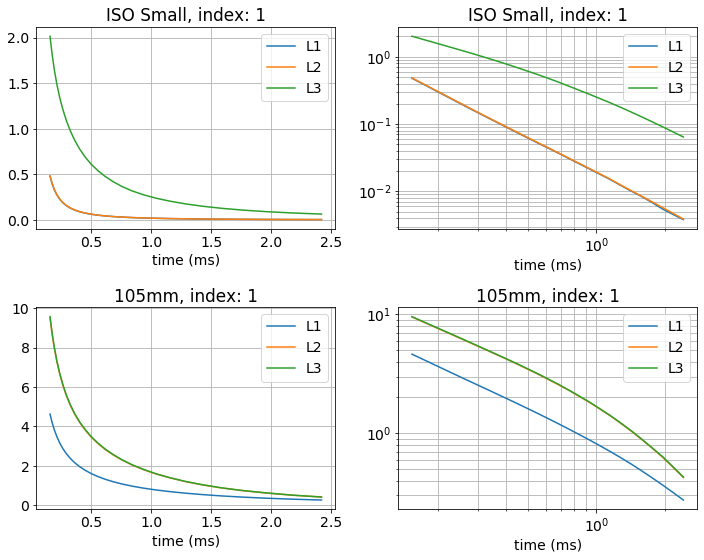

In [13]:
fig, ax = plt.subplots(len(ordnance.keys()), 2, figsize=(10, 4*len(ordnance.keys())))

for i, key in enumerate(ordnance.keys()):
    for l in ["L1", "L2", "L3"]:
        L = ordnance[key][l]
        ax[i, 0].plot(times, L, label=l)
        ax[i, 1].loglog(times, L, label=l)

    for a in ax[i, :]:
        a.set_title(f"{key}, index: {1}")
        a.grid(which="both")
        a.legend()
        a.set_xlabel("time (ms)")
plt.tight_layout()

# ranges of parameters

In [14]:
depth_range_iso_small = np.r_[0.2, 0.7]
depth_range_105mm = np.r_[0.1, 0.5]

x_range = np.r_[-1.25, 1.25]
y_range = np.r_[0., ymax]

yaw_range = np.r_[0, 2*np.pi]
pitch_range = np.r_[0, 2*np.pi]
roll_range = np.r_[0, 2*np.pi]

def generate_random_variables(n, bounds):
    return bounds.min() + (bounds.max() - bounds.min()) * np.random.rand(n)

In [15]:
ntrain = 2048
ntest = 1024
nvalid = 1024

class_dict = {
    0: "not TOI",
    1: "ISO Small",
    2: "105mm"
}
n_class = len(class_dict.keys())

In [16]:
labels_train = np.random.choice(n_class, ntrain)
labels_test = np.random.choice(n_class, ntest)
labels_valid = np.random.choice(n_class, nvalid)

def generate_parameters(labels):
    n = len(labels)
    i0 = labels == 0
    i1 = labels == 1
    i2 = labels == 2
    
    depths = np.zeros(n)
    depths[i1] = generate_random_variables(i1.sum(), depth_range_iso_small)
    depths[i2] = generate_random_variables(i2.sum(), depth_range_105mm)
    
    x = generate_random_variables(n, x_range)
    y = generate_random_variables(n, y_range)
    z = -depths
    
    yaw = generate_random_variables(n, yaw_range)
    pitch = generate_random_variables(n, pitch_range)
    roll = generate_random_variables(n, roll_range)
    
    return pd.DataFrame({
        "label": labels,
        "depth": depths,
        "x": x,
        "y": y,
        "z": z,
        "yaw": yaw,
        "pitch": pitch,
        "roll": roll
    })

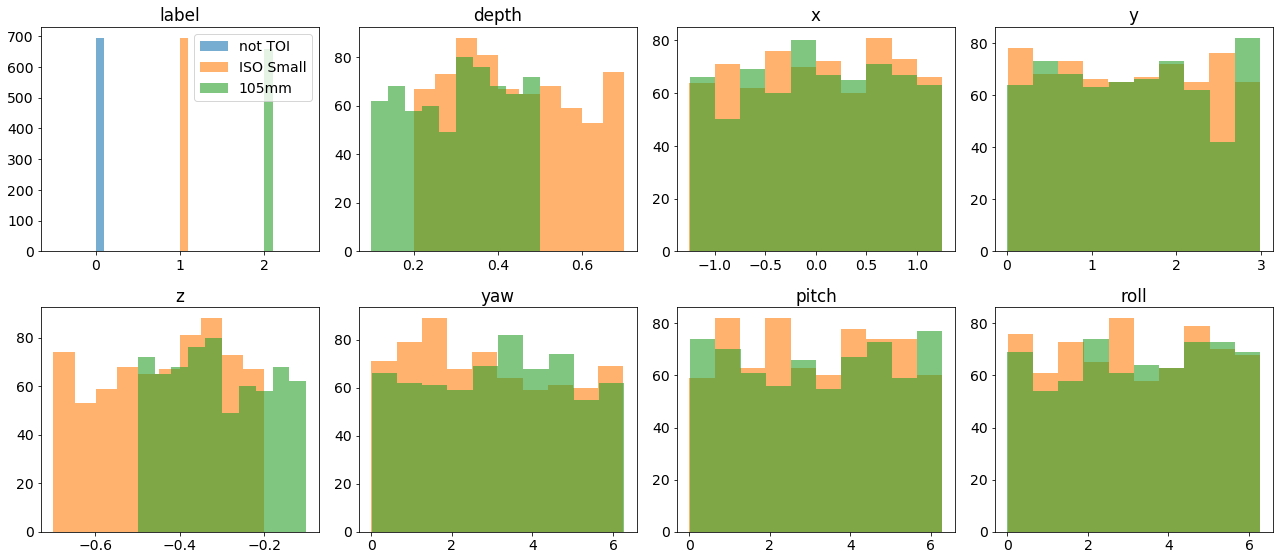

In [17]:
params_train = generate_parameters(labels_train) 
params_test = generate_parameters(labels_test) 
params_valid = generate_parameters(labels_valid) 

fig, ax = plt.subplots(2, 4, figsize=(18, 8))
ax = ax.flatten()

i = 0
for key, val in params_train.items():
    for j in range(3):
        if key != "label" and j ==0: 
            pass  # these parameters are irrelevant if there is no object
        else:
            inds = labels_train == j
            ax[i].hist(val[inds], 10, color=f"C{j}", alpha=0.6)
    ax[i].set_title(key)
    i += 1

ax[0].legend([class_dict[0], class_dict[1], class_dict[2]])
plt.tight_layout()

# set up forward simulations

In [18]:
def noise_model(times, amplitude=0.1, slope=-1, intercept=-0.5):
    return amplitude * np.exp(slope * np.log(times) + intercept)

In [19]:
# figuring out where all of the vertices are in coordinate system -- gives us location of vertices 
Tx_indices_rot, Rx_indices_rot = preCalcLoopCorners(
    sensorinfo=sensorinfo, mnum=mnum, rlist=pos, pitch=pitch, roll=roll, yaw=yaw
) 

# convienence object for inputs to fwd modelling 
st = FModParam(sensorinfo, pos, mnum, times, Tx_indices_rot, Rx_indices_rot)  

In [20]:
def run_simulations(parameters):
    data = []
    noise = []
    for i, l in enumerate(parameters["label"]):
        if l == 0:
            # this can later be replaced with random noise or other structured but uninteresting signal
            V = np.zeros((pos.shape[0], len(times)))
        else: 
            xyz = np.r_[parameters["x"][i], parameters["y"][i], parameters["z"][i]]
            ypr = np.r_[parameters["yaw"][i], parameters["pitch"][i], parameters["roll"][i]]
            L3 = ordnance[class_dict[l]]["L3"]
            L2 = ordnance[class_dict[l]]["L2"]
            L1 = ordnance[class_dict[l]]["L1"]
            
            mod = Model(xyz=xyz, gba=ypr, l3=L3, l2=L2, l1=L1, times=times)
            V = forwardWithQ(mod, st) # nT/s (some version of db/dt)
        V = V.reshape(ncycles, mnum.max()+1, len(times))
        V = np.swapaxes(V, 0, 1)
        data.append(V)
        noise.append(np.random.randn(np.prod(V.shape)).reshape(V.shape) * noise_model(times))
        
    return data, noise
    
    

In [21]:
%%time
data_clean_train, noise_train = run_simulations(params_train)
data_train = [d + n for d, n in zip(data_clean_train, noise_train)]

CPU times: user 32.1 s, sys: 785 ms, total: 32.9 s
Wall time: 5.79 s


In [22]:
%%time
data_clean_test, noise_test = run_simulations(params_test)
data_clean_valid, noise_valid = run_simulations(params_valid)

data_test = [d + n for d, n in zip(data_clean_test, noise_test)]
data_valid = [d + n for d, n in zip(data_clean_valid, noise_valid)]

CPU times: user 32.7 s, sys: 855 ms, total: 33.5 s
Wall time: 5.92 s


## plot some sample data

In [23]:
pos = np.swapaxes(pos.reshape(ncycles, mnum.max()+1, 3), 0, 1)

In [24]:
dind = 10
d = data_train[dind]

print(f"class: {class_dict[labels_train[dind]]}, data shape: {d.shape}")

params_train.iloc[dind]

class: ISO Small, data shape: (165, 15, 27)


label    1.000000
depth    0.276176
x        0.640611
y        0.534161
z       -0.276176
yaw      6.072661
pitch    2.468294
roll     0.735452
Name: 10, dtype: float64

In [25]:
# tx_num, rx_num, rx_comp, rxcube
sensor_table = sensorinfo.measNum2TxRxRxcCube()

In [26]:
len(sensor_table)

165

Text(0.5, 0.92, 'Transmitter 2, Target 10: ISO Small')

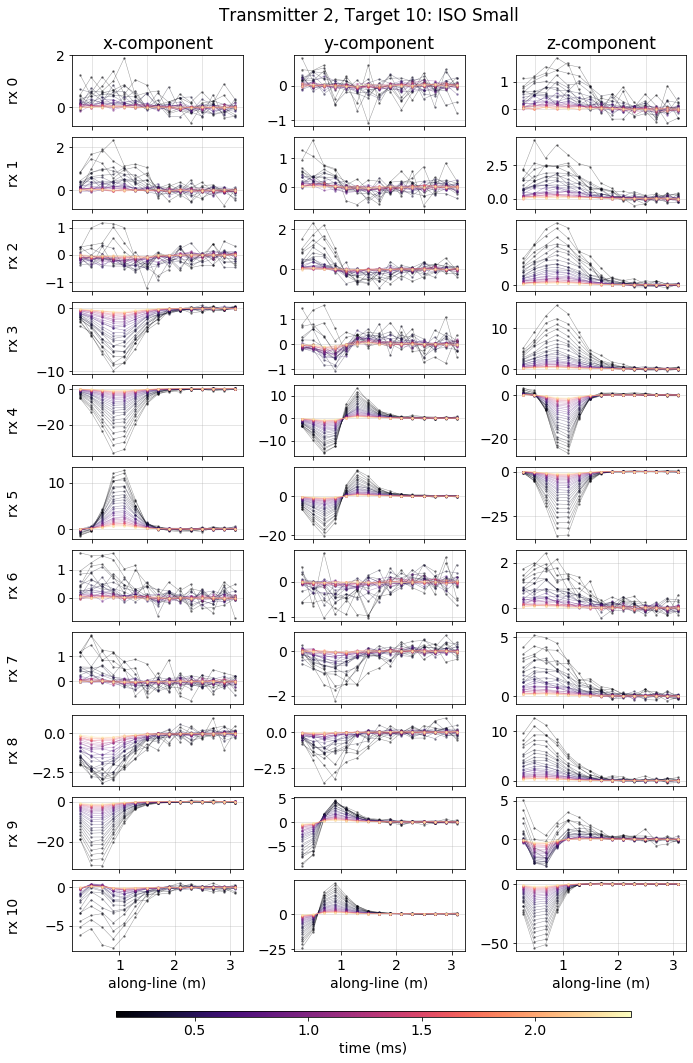

In [27]:
nrx = 11
fig, ax = plt.subplots(nrx, 3, figsize=(11, 1.5*nrx))
fig.subplots_adjust(wspace=0.3, hspace=0.15)

plot_tx = 1
tx_inds = (sensor_table[:, 0] == plot_tx)

cm = plt.get_cmap('magma')
c_norm = Normalize(vmin=times.min(), vmax=times.max())
scalar_map = cmap.ScalarMappable(norm=c_norm, cmap=cm)
scalar_map.set_array([])

for rx in range(nrx):
    ii = tx_inds & (sensor_table[:, 3] == rx)
    for a, comp in zip(ax[rx, :], [0, 1, 2]):
        mnumind = np.where( ii & (sensor_table[:, 2] == comp))[0][0]
        for t in range(len(times)):
            a.plot(
                pos[mnumind, :, 1], d[mnumind, :, t], 
                color=scalar_map.to_rgba(times[t]), marker=".", lw=0.5, alpha=0.4, ms=3
            )

        a.grid(which="both", alpha=0.4)
        if rx < nrx-1:
            a.set_xticklabels('')
        else:
            a.set_xlabel("along-line (m)")
        
        if rx == 0:
            if comp == 0:
                a.set_title("x-component")
            elif comp == 1:
                a.set_title("y-component")
            elif comp == 2:
                a.set_title("z-component")
        
        if comp == 0:
            a.set_ylabel(f"rx {rx}")
            a.yaxis.set_label_coords(-0.3, 0.5)
            
# plt.tight_layout()
cbar_ax = fig.add_axes([0.18, 0.07, 0.65, 0.005])
cb = plt.colorbar(scalar_map, cbar_ax, orientation="horizontal")
cb.set_label('time (ms)')

fig.suptitle(f"Transmitter {plot_tx+1}, Target {dind}: {class_dict[labels_train[dind]]}", y=0.92)


# build a CNN classifier 

In [28]:
import torch
from torch import nn
from torch.nn import functional

In [29]:
class ConvNet(nn.Module):
    
    def __init__(self, network_geometry, h=1, npool=3):
        super().__init__()
        self.h = h
        self.network_geometry=network_geometry
        self.nt = len(network_geometry)
#         self.npool = npool
    
    def forward(self, X, K, batch_norm):
            
        for i, Ki, bn in zip(range(self.nt), K, batch_norm): 
            z = functional.conv2d(X, Ki, stride=1, padding=1)
            z = bn(z)
            z = functional.relu(z)
            
#             for i in range(self.npool):
#                 z = functional.avg_pool2d(z, 2, stride=1, padding=1)
            
                
#             if self.network_geometry[i] == self.network_geometry[i+1]:
#                 z = functional.conv_transpose2d(z, Ki, stride=1, padding=1)
# #                 X = X - self.h*z
#             else: 
            X = z
        return X

In [30]:
in_channels = 165
n_class = 3
layer_geometries = [in_channels, 4, 4]
nlayers = len(layer_geometries)
initial_scaling = 1

width = nloc//ntx
ntimes = len(times)

batch_size = 32 
net = ConvNet(layer_geometries, h=1)

# initialize K's and batch normalizations
K = []
batch_norm = []
for i in range(nlayers-1):
    n_in = layer_geometries[i]
    n_out = layer_geometries[i+1]
    Ki = nn.Parameter(torch.Tensor(n_out, n_in, 3, 3))
    Ki.data = torch.randn(n_out, n_in, 3, 3)  * initial_scaling
    K.append(Ki)
    
    batch_norm.append(nn.BatchNorm2d(n_out))

# initialize classifier W
W = nn.Parameter(torch.Tensor(layer_geometries[-1]*width*ntimes, n_class))
W.data = torch.randn(layer_geometries[-1]*width*ntimes, n_class)

In [31]:
net = ConvNet(layer_geometries)

In [32]:
X_train = torch.from_numpy(np.float32(np.stack(data_train, axis=0)))
X_test = torch.from_numpy(np.float32(np.stack(data_test, axis=0)))
X_valid = torch.from_numpy(np.float32(np.stack(data_valid, axis=0)))

C_train = torch.from_numpy(np.float32(labels_train)).long()
C_test = torch.from_numpy(np.float32(labels_test)).long()
C_valid = torch.from_numpy(np.float32(labels_valid)).long()

In [33]:
# run the network

with torch.no_grad():
    out = net(X_train, K, batch_norm)

In [34]:
loss_func = nn.CrossEntropyLoss()

def misfit(X, W, C):
    n = W.shape
    X = X.view(-1, n[0])
    S = torch.matmul(X, W)

    probs = functional.softmax(S, dim=1)
    return loss_func(S, C), probs

In [35]:
K0 = K[0]

In [36]:
n_parout = (
    np.sum(np.array([np.prod(Ki.shape) for Ki in K])) + np.prod(W.shape)
)

print('Total number of parameters',n_parout)
print('Total number of data', labels_train.shape[0])

Total number of parameters 10944
Total number of data 2048


In [37]:
loss, probs = misfit(out, W, C_train)
print('Initial loss = ', loss.detach().numpy())    
print(f'Check:log({n_class}) = ', np.log(n_class))

Initial loss =  6.439503
Check:log(3) =  1.0986122886681098


In [38]:
batch_size = 32

In [39]:
import torch.optim as optim
optimizer = optim.SGD(
    [{'params': W}, {'params': K}], 
    lr = 1e0, momentum=0
)


In [40]:
def accuracy(S, labels):
    _, predicted = torch.max(S, dim=1)
    total = np.prod(labels.size())
    correct = (predicted == labels).sum().item()
    return correct/total

In [41]:
all_loss = []
all_test_loss = []

for epoch in range(200):  # loop over the dataset multiple times

    # zero the parameter gradients
    g = 0.0
    loss = 0.0
    ind = 0
    
    while ind < X_train.shape[1]:    
        optimizer.zero_grad()
        # get the inputs
        inputs = X_train[ind:ind+batch_size, :, :, :]
        labels = C_train[ind:ind+batch_size]

        # forward 
        x = net(inputs, K, batch_norm)
        lossi, _ = misfit(x, W, labels)
        if i==0:
            loss = lossi
        else:
            loss += lossi
        lossi.backward()
        optimizer.step()
        ind += batch_size
    
    if np.mod(epoch, 10) == 0: 
        with torch.no_grad():
            xtest = net(X_test, K, batch_norm)
            loss_test, probs_test = misfit(xtest, W, C_test)

            xtrain = net(X_train, K, batch_norm)
            loss_train, probs_train = misfit(xtrain, W, C_train)

            accuracy_train = accuracy(probs_train, C_train)
            accuracy_test = accuracy(probs_test, C_test)

        print(f'{epoch+1:3d}  {loss:2.3f}  {loss_test:2.3f}  {accuracy_train:0.3f}  {accuracy_test:0.3f}')

print('Finished Training')

  1  30.654  1.902  0.617  0.618
 11  2.105  0.682  0.625  0.627
 21  0.911  0.566  0.906  0.892
 31  0.605  0.556  0.936  0.918
 41  0.372  0.536  0.945  0.937
 51  0.211  0.522  0.950  0.944
 61  0.141  0.520  0.956  0.950
 71  0.105  0.538  0.964  0.951
 81  0.083  0.557  0.967  0.953
 91  0.068  0.575  0.967  0.957
101  0.058  0.609  0.967  0.957
111  0.050  0.641  0.966  0.956
121  0.043  0.670  0.967  0.955
131  0.038  0.698  0.967  0.955
141  0.034  0.716  0.967  0.956
151  0.030  0.730  0.969  0.956
161  0.028  0.740  0.969  0.956
171  0.025  0.750  0.969  0.955
181  0.023  0.758  0.970  0.956
191  0.021  0.766  0.970  0.955
Finished Training


In [42]:
# training set
x_train_net = net(X_train, K, batch_norm)
_, probs_train = misfit(x_train_net, W, C_train)
_, pred_train = torch.max(probs_train, dim=1)

# test set
x_test_net = net(X_test, K, batch_norm)
_, probs_test = misfit(x_test_net, W, C_test)
_, pred_test = torch.max(probs_test, dim=1)

# validation set
x_valid_net = net(X_valid, K, batch_norm)
_, probs_valid = misfit(x_valid_net, W, C_valid)
_, pred_valid = torch.max(probs_valid, dim=1)

In [43]:
print(f"training accuracy: {accuracy(probs_train, C_train):1.4f}")
print(f"test accuracy    : {accuracy(probs_test, C_test):1.4f}")
print(f"valid accuracy   : {accuracy(probs_valid, C_valid):1.4f}")

training accuracy: 0.9697
test accuracy    : 0.9561
valid accuracy   : 0.9531


In [44]:
# see where it struggled

def get_mislabeled(S, labels):
    _, predicted = torch.max(S, dim=1)
    incorrect = (predicted != labels)
    return incorrect.numpy()

In [45]:
mislabeled_train = get_mislabeled(probs_train, C_train)
mislabeled_test = get_mislabeled(probs_test, C_test)
mislabeled_valid = get_mislabeled(probs_valid, C_valid)

print(f"Mislabeled. train: {mislabeled_train.sum()}, test: {mislabeled_test.sum()}, valid: {mislabeled_valid.sum()}")

Mislabeled. train: 62, test: 45, valid: 48


In [46]:
params_train.loc[mislabeled_train]

,label,depth,x,y,z,yaw,pitch,roll
84,2,0.471157,0.766710,2.927706,-0.471157,3.224803,4.222782,3.488857
293,1,0.252584,1.073413,0.909931,-0.252584,3.132317,5.573847,5.303812
297,2,0.485359,0.487581,2.922337,-0.485359,2.959624,1.915134,4.779499
319,2,0.495399,-0.977435,0.328015,-0.495399,5.062067,1.007049,3.266975
337,2,0.159138,0.324338,1.482357,-0.159138,2.171148,0.392775,5.395566
...,...,...,...,...,...,...,...,...
1964,1,0.258165,-0.206296,1.690905,-0.258165,4.650614,3.387940,4.717871
1966,2,0.459955,0.772462,0.394191,-0.459955,4.464224,1.809229,2.397598
1976,1,0.323525,-0.055619,0.544820,-0.323525,4.885101,6.216616,1.771439
1993,1,0.214600,-0.187211,1.237115,-0.214600,3.032230,3.518335,0.866342


In [47]:
probs_train[mislabeled_train]

tensor([[0.0000e+00, 8.4976e-01, 1.5024e-01],
        [1.5997e-29, 1.8672e-03, 9.9813e-01],
        [2.8026e-45, 7.5917e-01, 2.4083e-01],
        [1.0229e-43, 9.9995e-01, 4.9515e-05],
        [0.0000e+00, 1.0000e+00, 4.8981e-21],
        [0.0000e+00, 3.9915e-19, 1.0000e+00],
        [5.6052e-45, 5.1267e-01, 4.8733e-01],
        [3.1285e-38, 3.4419e-03, 9.9656e-01],
        [2.9755e-37, 9.9907e-01, 9.3408e-04],
        [9.2376e-38, 9.9995e-01, 4.7159e-05],
        [7.7788e-28, 1.1509e-15, 1.0000e+00],
        [2.1160e-43, 1.6858e-09, 1.0000e+00],
        [6.4460e-44, 1.0000e+00, 1.4724e-11],
        [3.0028e-27, 3.0426e-01, 6.9574e-01],
        [2.4011e-31, 1.4604e-03, 9.9854e-01],
        [0.0000e+00, 9.9842e-01, 1.5827e-03],
        [9.6205e-32, 4.4535e-06, 1.0000e+00],
        [3.0829e-44, 5.8874e-01, 4.1126e-01],
        [1.6632e-26, 1.5063e-02, 9.8494e-01],
        [4.4211e-33, 8.9461e-01, 1.0539e-01],
        [4.1181e-34, 9.5263e-01, 4.7374e-02],
        [5.8007e-33, 1.0000e+00, 1

In [48]:
params_test.loc[mislabeled_test]

,label,depth,x,y,z,yaw,pitch,roll
52,2,0.414557,0.574988,0.247635,-0.414557,0.313440,2.582670,4.894585
60,1,0.683935,-1.223920,1.732406,-0.683935,0.733162,0.593610,4.978192
62,1,0.223794,0.240501,1.936220,-0.223794,3.818147,3.187887,5.204398
64,2,0.496337,0.590796,0.586632,-0.496337,3.971957,6.226642,4.824314
66,2,0.444707,1.170229,0.359785,-0.444707,0.152379,3.153381,0.814217
74,1,0.227919,-0.398670,0.921296,-0.227919,2.028650,3.819217,3.308169
108,2,0.369400,0.765316,0.073444,-0.369400,2.390405,4.839576,0.466313
130,2,0.480732,0.430764,1.936359,-0.480732,3.993958,2.536572,3.847701
146,2,0.421879,-1.042626,0.163851,-0.421879,4.097700,1.411194,0.372335
219,2,0.454759,0.335414,0.289976,-0.454759,0.197402,5.343378,1.199338


In [49]:
probs_test[mislabeled_test]

tensor([[0.0000e+00, 1.0000e+00, 1.7865e-06],
        [7.2738e-01, 2.7261e-01, 1.1386e-05],
        [1.2265e-29, 8.4714e-03, 9.9153e-01],
        [0.0000e+00, 9.9866e-01, 1.3384e-03],
        [0.0000e+00, 9.9988e-01, 1.1768e-04],
        [1.1209e-36, 8.8860e-04, 9.9911e-01],
        [0.0000e+00, 1.0000e+00, 2.0122e-08],
        [0.0000e+00, 7.1316e-01, 2.8684e-01],
        [7.0065e-45, 1.0000e+00, 3.9796e-06],
        [0.0000e+00, 8.5364e-01, 1.4636e-01],
        [0.0000e+00, 6.0523e-05, 9.9994e-01],
        [0.0000e+00, 1.0000e+00, 4.6206e-11],
        [0.0000e+00, 3.2536e-29, 1.0000e+00],
        [0.0000e+00, 1.0000e+00, 3.3995e-24],
        [0.0000e+00, 8.9761e-01, 1.0239e-01],
        [0.0000e+00, 1.9485e-10, 1.0000e+00],
        [1.9447e-32, 9.3740e-01, 6.2604e-02],
        [0.0000e+00, 1.0000e+00, 1.9290e-10],
        [0.0000e+00, 9.9971e-01, 2.9458e-04],
        [3.4052e-43, 9.7697e-01, 2.3025e-02],
        [2.2666e-41, 1.2601e-06, 1.0000e+00],
        [0.0000e+00, 1.0000e+00, 3

In [50]:
params_valid.loc[mislabeled_valid]

,label,depth,x,y,z,yaw,pitch,roll
7,1,0.222326,0.966539,2.111976,-0.222326,3.397379,2.955970,1.568512
24,1,0.227210,-0.970567,1.123524,-0.227210,0.975267,3.452208,1.783177
77,1,0.338795,-0.267101,1.994275,-0.338795,0.964436,0.216444,5.211370
104,1,0.283479,0.043854,1.836425,-0.283479,3.125380,2.605069,5.494626
112,2,0.368412,0.532064,1.460397,-0.368412,3.184925,2.924421,0.242337
137,2,0.392527,0.447312,1.012868,-0.392527,4.066507,6.056013,5.209282
153,2,0.324038,0.357288,1.921936,-0.324038,5.545509,2.998418,5.920003
172,2,0.468283,0.241470,0.017258,-0.468283,5.874705,4.761994,0.720153
235,1,0.292402,-0.271388,0.939393,-0.292402,1.097366,2.860993,1.474504
238,2,0.459538,-1.074677,0.304815,-0.459538,1.915492,1.379735,0.036243


In [51]:
probs_valid[mislabeled_valid]

tensor([[0.0000e+00, 1.2567e-07, 1.0000e+00],
        [1.3809e-19, 7.5600e-04, 9.9924e-01],
        [0.0000e+00, 2.1216e-03, 9.9788e-01],
        [7.8473e-44, 2.2302e-10, 1.0000e+00],
        [0.0000e+00, 9.8831e-01, 1.1692e-02],
        [0.0000e+00, 1.0000e+00, 2.2759e-06],
        [0.0000e+00, 9.9816e-01, 1.8404e-03],
        [0.0000e+00, 1.0000e+00, 1.1052e-09],
        [4.3835e-23, 2.4727e-03, 9.9753e-01],
        [3.2370e-43, 9.9977e-01, 2.3447e-04],
        [0.0000e+00, 5.7175e-01, 4.2825e-01],
        [1.5414e-44, 1.0622e-12, 1.0000e+00],
        [0.0000e+00, 9.9513e-01, 4.8679e-03],
        [1.5463e-40, 9.9999e-01, 7.8655e-06],
        [0.0000e+00, 1.0000e+00, 5.0114e-08],
        [0.0000e+00, 5.6457e-09, 1.0000e+00],
        [0.0000e+00, 7.5320e-01, 2.4680e-01],
        [2.1183e-33, 9.9998e-01, 2.0781e-05],
        [0.0000e+00, 1.0000e+00, 2.5171e-08],
        [0.0000e+00, 9.0346e-01, 9.6542e-02],
        [0.0000e+00, 4.3033e-09, 1.0000e+00],
        [0.0000e+00, 1.0000e+00, 8

# load up a line from the test site

In [52]:
data_directory = "../UXO_protected/data-blacktusk"
groundtruth = pd.read_excel(os.path.sep.join([data_directory, "groundtruth_Testplot5F.xlsx"]), nrows=93)

In [53]:
groundtruth = pd.read_excel(os.path.sep.join([data_directory, "groundtruth_Testplot5F.xlsx"]), nrows=93)

In [54]:
# H5 functions
def proc_attr(inp):
    """HDF5 - Process attributes for the input group and return them in a dictionary."""
    dic = {}
    for att in inp.attrs.keys():
        if inp.attrs[att].dtype.char == 'S':
            dic[att] = [x.strip() for x in inp.attrs[att].tostring().decode('ascii').split(',')]
        else:
            dic[att] = inp.attrs[att][0] if isinstance(inp.attrs[att],np.ndarray) and inp.attrs[att].size==1 else inp.attrs[att]
    return dic
    pass

def proc_group(inp):
    """HDF5 - A recursive function for reading datasets and attributes into a dictionary."""
    dic = {}
    dic.update(proc_attr(inp))
    for key in inp.keys():
        if isinstance(inp[key], h5py.Group):
            dic.update({key:proc_group(inp[key])})
        else:
            dic[key] = inp[key][()]
        pass
    return dic

In [55]:
dfile = os.path.join(data_directory, 'Testplot5F.h5')
f = h5py.File(dfile, 'r')
dic = proc_group(f)
f.close()

In [56]:
# Generate the sensorinfo structure
sensor_name = dic['SensorName'][0]
sensor_config = dic['SensorConfig'][0]
afile = os.path.join(code_dir,'config','sensor_definitions','{}___{}.yaml'.format(sensor_name,sensor_config))
sensorinfo = SensorInfo.fromYAML(afile)[0]

print(sensor_name)

UltraTEMArrayNA


In [57]:
xyz_dict = dic["XYZ"]
ch = xyz_dict['Info']['ChannelNames']
datai = xyz_dict['Info']['Data']['ChannelIndex'].flatten().astype(int)-1 # These are indices to the decay data
yawi = int(xyz_dict['Info']['Yaw']['ChannelIndex'])-1 # index to the yaw channel
mni = int(xyz_dict["Info"]["MeasNum"]["ChannelIndex"])-1
easting = int(xyz_dict["Info"]["Easting"]["ChannelIndex"])-1
northing = int(xyz_dict["Info"]["Northing"]["ChannelIndex"])-1
linesi = int(xyz_dict["Info"]["Line"]["ChannelIndex"])-1
rx_num = int(xyz_dict["Info"]["RxNum"]["ChannelIndex"])-1
tx_num = int(xyz_dict["Info"]["TxNum"]["ChannelIndex"])-1
rx_comp = int(xyz_dict["Info"]["RxCNum"]["ChannelIndex"])-1
rx_num = int(xyz_dict["Info"]["RxNum"]["ChannelIndex"]) - 1

times = np.array(dic['SensorTimes'].flatten())
print(times.min(), times.max(), len(times))

0.154 2.42 27


In [58]:
xyz_data = xyz_dict["Data"]
mn = xyz_data[mni, :].astype(int) - 1

In [59]:
line_id = 1013 #, 1013]
line_inds = xyz_data[linesi, :] == line_id
print(sum(line_inds))

66825


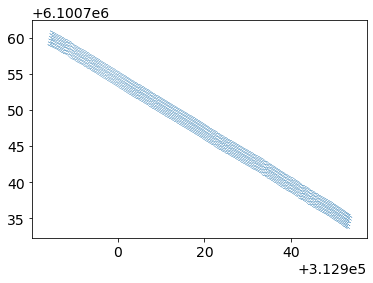

In [60]:
fig, ax = plt.subplots(1, 1)
ax.plot(xyz_data[easting, line_inds], xyz_data[northing, line_inds], '.', alpha=0.1, ms=0.2)

In [61]:
from scipy import stats

In [62]:
# local coordinates for the data set 
x0, y0 = np.mean(xyz_data[easting, :]), np.mean(xyz_data[northing, :])
local_easting = xyz_data[easting, :] - x0
local_northing = xyz_data[northing, :] - y0

slope, intercept, _, _, _ = stats.linregress(local_easting, local_northing)
print(slope, intercept)

-0.3486944749895923 6.346738382583072e-10


In [63]:
theta = np.arctan(slope)+np.pi/2
local_x = np.cos(theta) * local_easting + np.sin(theta) * local_northing
local_y = -np.sin(theta) * local_easting + np.cos(theta) * local_northing


local_ground_truth_easting = np.array(groundtruth["Easting"] - x0)
local_ground_truth_northing = np.array(groundtruth["Northing"] - y0)
local_ground_truth_x = np.cos(theta) * local_ground_truth_easting + np.sin(theta) * local_ground_truth_northing
local_ground_truth_y = -np.sin(theta) * local_ground_truth_easting + np.cos(theta) * local_ground_truth_northing


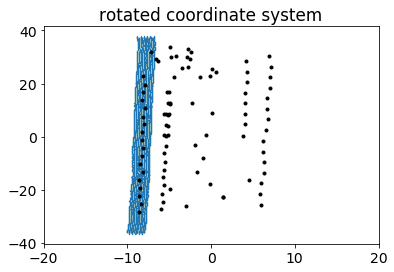

In [64]:
line_x = local_x[line_inds]
line_y = local_y[line_inds]

mn_line = mn[line_inds]
fig, ax = plt.subplots(1, 1)
ax.plot(line_x, line_y, '.', ms=0.1)
ax.set_xlim(np.r_[-20, 20])
ax.set_title("rotated coordinate system")

ax.plot(local_ground_truth_x, local_ground_truth_y, 'k.', label="ordnance")

In [65]:
ord_inds_covered = (
    (local_ground_truth_x >= line_x.min()) & (local_ground_truth_x <= line_x.max()) &
    (local_ground_truth_y >= line_y.min()) & (local_ground_truth_y <= line_y.max())
)

Text(0, 0.5, 'y (m)')

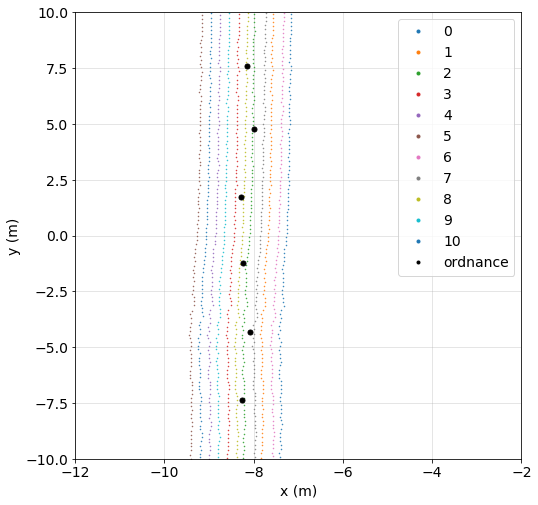

In [66]:
mn_line = mn[line_inds]
fig, ax = plt.subplots(1, 1, figsize=(8, 14))

for plot_mn in range(11):

    plot_inds = (mn_line==plot_mn)
    ax.plot(line_x[plot_inds], line_y[plot_inds], '.', ms=1, label=plot_mn)

ax.plot(
    local_ground_truth_x[ord_inds_covered], local_ground_truth_y[ord_inds_covered], 'k.', label="ordnance", ms=10
)
lgnd = ax.legend()
[h._legmarker.set_markersize(6) for h in lgnd.legendHandles]

ax.set_xlim([-12, -2])
ax.set_ylim([-10, 10])
ax.grid("both", alpha = 0.4)
ax.set_aspect(0.5)
ax.set_xlabel("x (m)")
ax.set_ylabel("y (m)")

In [67]:
# target data shape 165 X nlocs X nTimes 
# grab by measurement number 
# then re-stack

x_locs = []
y_locs = []
data_list = []
line_data = xyz_data[datai, :][:, line_inds]

for mnind in range(mn.max() + 1):
    mninds = mn_line == mnind
    x_locs.append(line_x[mninds])
    y_locs.append(line_y[mninds])
    data_list.append(line_data[:, mninds].T)

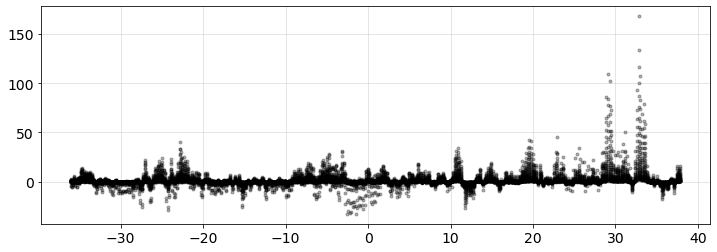

In [68]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
ax.plot(y_locs[0], data_list[0], '.', color="k", alpha=0.3)
ax.grid("both", alpha=0.4)

In [69]:
X_locs = np.vstack(x_locs)
Y_locs = np.vstack(y_locs)
S_data = np.stack(data_list, axis=0)
print(S_data.shape)

(165, 405, 27)


In [70]:
window_width = int(ymax/y_spacing)
w_step = 5
n_windows = (X_locs.shape[1]-window_width)//w_step + 1
print(n_windows)

79


In [71]:
n = S_data.shape
net_data = np.zeros((n_windows, n[0], window_width, n[2]))
net_y = np.zeros((n_windows, n[0], window_width))
net_x = np.zeros((n_windows, n[0], window_width))

for i in range(n_windows):
    inds = slice(i*w_step,i*w_step+window_width)
    net_x[i, :, :] = X_locs[:, inds]
    net_y[i, :, :] = Y_locs[:, inds]
    net_data[i, :, :, :] = S_data[:, inds, :]

In [72]:
net_data_torch = torch.from_numpy(np.float32(net_data))

In [73]:
with torch.no_grad():
    out_field = net(net_data_torch, K, batch_norm)
    n = W.shape
    S = torch.matmul(out_field.view(-1, n[0]), W)
    probs_field = functional.softmax(S, dim=1)

In [74]:
probs_field

tensor([[2.8242e-25, 1.0000e+00, 1.1044e-08],
        [3.9045e-23, 1.0000e+00, 1.1704e-11],
        [8.0448e-31, 9.9998e-01, 2.0195e-05],
        [0.0000e+00, 7.3196e-17, 1.0000e+00],
        [5.0867e-43, 1.1506e-15, 1.0000e+00],
        [0.0000e+00, 8.0593e-09, 1.0000e+00],
        [4.5139e-38, 2.1384e-04, 9.9979e-01],
        [0.0000e+00, 4.9987e-10, 1.0000e+00],
        [8.2326e-34, 3.8096e-07, 1.0000e+00],
        [1.2154e-17, 1.4519e-01, 8.5481e-01],
        [9.5267e-08, 9.9902e-01, 9.8112e-04],
        [9.3224e-01, 6.3924e-02, 3.8330e-03],
        [1.7876e-09, 1.0000e+00, 4.5409e-06],
        [0.0000e+00, 0.0000e+00, 1.0000e+00],
        [0.0000e+00, 4.8215e-26, 1.0000e+00],
        [0.0000e+00, 0.0000e+00, 1.0000e+00],
        [0.0000e+00, 1.3559e-10, 1.0000e+00],
        [3.6319e-30, 9.9984e-01, 1.5514e-04],
        [0.0000e+00, 3.7825e-15, 1.0000e+00],
        [0.0000e+00, 0.0000e+00, 1.0000e+00],
        [0.0000e+00, 0.0000e+00, 1.0000e+00],
        [0.0000e+00, 0.0000e+00, 1

In [75]:
_, labels_field = torch.max(probs_field, axis=1)

In [76]:
from matplotlib.lines import Line2D

(-50, 50)

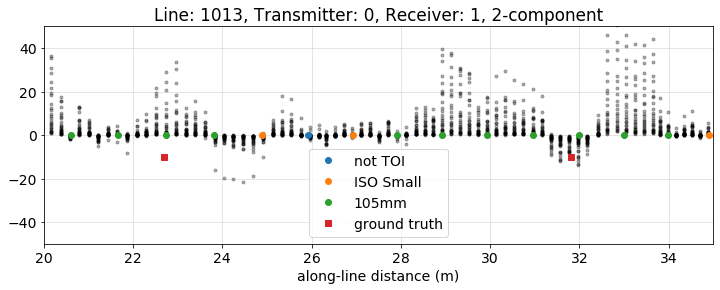

In [81]:
mnum_plot = 1
fig, ax = plt.subplots(1, 1, figsize=(12, 4))

ordnance_labels = [
    Line2D(
        [0], [0], marker='o', color="w", 
        markerfacecolor=f'C{int(key)}', markeredgecolor=f'C{int(key)}', 
        label=value
    ) for key, value in class_dict.items()
]

ordnance_labels.append(
    Line2D(
        [0], [0], marker='s', color="w", 
        markerfacecolor=f'C3', markeredgecolor=f'C3', 
        label="ground truth"
    )
)

ax.plot(y_locs[mnum_plot], data_list[mnum_plot], '.', color="k", alpha=0.3)
ax.grid("both", alpha=0.4)

for i in range(net_data.shape[0]):
    y_plot = np.mean(net_y[i, mnum_plot, :])
    ax.plot(y_plot, 0, f'C{labels_field[i]}o')

txnumplot = sensor_table[mnum_plot, 0]
rxnumplot = sensor_table[mnum_plot, 3]
rxcompplot = sensor_table[mnum_plot, 2]
ax.set_title(f"Line: {line_id}, Transmitter: {txnumplot}, Receiver: {rxnumplot}, {rxcompplot}-component")
ax.set_xlabel("along-line distance (m)")
ax.plot(local_ground_truth_y[ord_inds_covered], -10*np.ones(ord_inds_covered.sum()), "sC3")

ax.legend(handles=ordnance_labels)

ax.set_xlim([20, 35])
ax.set_ylim([-50, 50])


In [78]:
groundtruth["ItemBuried"][ord_inds_covered]

9     Small ISO
10    Small ISO
11    Small ISO
12    Small ISO
13    Small ISO
14    Small ISO
15    Small ISO
16    Small ISO
17    Small ISO
18    Small ISO
19    Small ISO
20    Small ISO
21    Small ISO
22    Small ISO
23    Small ISO
24    Small ISO
25    Small ISO
26    Small ISO
84    Small ISO
Name: ItemBuried, dtype: object

In [79]:
groundtruth["Comment"][ord_inds_covered]

9     10_SmlISO_0.2_Ha
10    11_SmlISO_0.2_Hx
11     12_SmlISO_0.2_V
12    13_SmlISO_0.3_Ha
13    14_SmlISO_0.3_Hx
14     15_SmlISO_0.3_V
15    16_SmlISO_0.4_Ha
16    17_SmlISO_0.4_Hx
17     18_SmlISO_0.4_V
18    19_SmlISO_0.5_Ha
19    20_SmlISO_0.5_Hx
20     21_SmlISO_0.5_V
21    22_SmlISO_0.6_Ha
22    23_SmlISO_0.6_Hx
23     24_SmlISO_0.6_V
24    25_SmlISO_0.7_Ha
25    26_SmlISO_0.7_Hx
26     27_SmlISO_0.7_V
84          Saturated 
Name: Comment, dtype: object